# Toy Example

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Packages

In [4]:
import numpy as np

# Data
from torch.utils.data import DataLoader, Dataset

# PyTorch
import torch
import torch.nn as nn

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger


# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt
import corner

import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [5]:
wandb_logger = WandbLogger(project="gfs4ml", entity="ipl_uv", experiment="demo_cifar10")

## Data

In [6]:
class Quantize():
    '''
    Assumes input takes values in {0,1,...255}/255, i.e. in [0,1].
    Note: This corresponds to the output of ToTensor().
    '''

    def __init__(self, num_bits=8):
        self.num_bits = num_bits

    def __call__(self, image):
        image = image * 255 # [0, 1] -> [0, 255]
        if self.num_bits != 8:
            image = torch.floor(image / 2 ** (8 - self.num_bits)) # [0, 255] -> [0, 2**num_bits - 1]
        return image.long()



In [7]:
from pl_bolts.datasets import CIFAR10
from pl_bolts.datamodules import CIFAR10DataModule
from torchvision.transforms import ToTensor, Compose

In [8]:
# Define transformations

num_bits = 8
trans_train = [ToTensor(), Quantize(num_bits)]
trans_test = [ToTensor(), Quantize(num_bits)]

# get datasets
ds_train = CIFAR10(train=True, transform=Compose(trans_train), data_dir="/datadrive/eman/survae_flows_lib/data")
ds_test = CIFAR10(train=False, transform=Compose(trans_train), data_dir="/datadrive/eman/survae_flows_lib/data")


# create dataloaders
batch_size = 32
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

In [9]:
from einops import rearrange
test_x = ds_test.data[:500]

test_x = rearrange(test_x, "B (C H W) -> B C H W", C=3, H=32, W=32)

## Model

In [10]:
# np.prod((n_channels, height, width))

In [11]:
# model = Flow(base_dist=StandardNormal((24,8,8)),
#              transforms=[
#                UniformDequantization(num_bits=8),
#                Augment(StandardUniform((3,32,32)), x_size=3),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                Squeeze2d(), Slice(StandardNormal((12,16,16)), num_keep=12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                Squeeze2d(), Slice(StandardNormal((24,8,8)), num_keep=24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#              ]).to(device)

In [12]:
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.conv1x1 import Conv1x1Householder
from survae.transforms.surjections.dequantization_uniform import UniformDequantization
from survae.transforms.bijections.reshape import Reshape
from survae.transforms.bijections.squeeze import Squeeze2d
from survae.transforms.surjections.slice import Slice

n_channels, height, width = 3, 32, 32
total_dims = np.prod((n_channels, height, width))




# transforms
num_mixtures = 8

transforms = [
    UniformDequantization(num_bits=8),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    GaussianMixtureCDF((3, 32, 32), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(3, 3),
    # (3,32,32) -> (12,16,16)
    Squeeze2d(), 
    # (12,16,16) -> (6,16,16)
    Slice(StandardNormal((6,16,16)), num_keep=6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    GaussianMixtureCDF((6,16,16), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(6, 6),
    # (6,16,16) -> (24,8,8)
    Squeeze2d(), 
    # (24,8,8) -> (12,8,8)
    Slice(StandardNormal((12,8,8)), num_keep=12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    GaussianMixtureCDF((12,8,8), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(12, 12),
    # (12,8,8) -> (48,4,4)
    Squeeze2d(), 
    # (48,4,4) -> (24,4,4)
    Slice(StandardNormal((24,4,4)), num_keep=24),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    GaussianMixtureCDF((24,4,4), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(24, 12),
    # (24,4,4) -> (96,2,2)
    Squeeze2d(), 
    # (96,2,2) -> (48,2,2)
    Slice(StandardNormal((48,2,2)), num_keep=48),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    GaussianMixtureCDF((48,2,2), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(48, 12),
    # (48,2,2) -> (192,)
    Reshape((48,2,2), (np.prod((48,2,2)),))
    
]

# base distribution
base_dist = StandardNormal((np.prod((48,2,2)),))

# flow model
model = Flow(base_dist=base_dist, transforms=transforms)


In [13]:
loss = model.log_prob(test_x)

In [14]:
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision.transforms.functional as tv_F
import numpy as np

In [15]:
# def plot_images(data, num_x, num_y):
#     fig, ax = plt.subplots(num_x, num_y)
#     for i, ax in enumerate(ax.flatten()):
#         plottable_image = data[i]

#         if data.ndim == 2:
#             plottable_image = np.reshape(plottable_image, (3, 32, 32))

#         ax.imshow(plottable_image.transpose([1, 2, 0]), cmap="gray")
#         ax.axis("off")
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tv_F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [16]:
test_x.min(), test_x.max()


(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

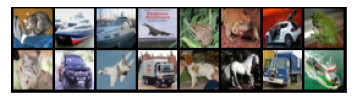

In [17]:
show(make_grid(test_x[:16]/255))

#### Demo: Forward & Inverse

In [18]:
%time
z, ldj = model.forward_transform(test_x)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [19]:
%time
x_approx = model.inverse_transform(z[:32])

CPU times: user 25 µs, sys: 5 µs, total: 30 µs
Wall time: 6.2 µs


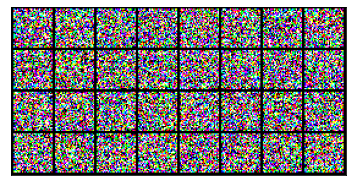

In [20]:
show(make_grid(x_approx[:32]/255))

#### Demo: Latent Space

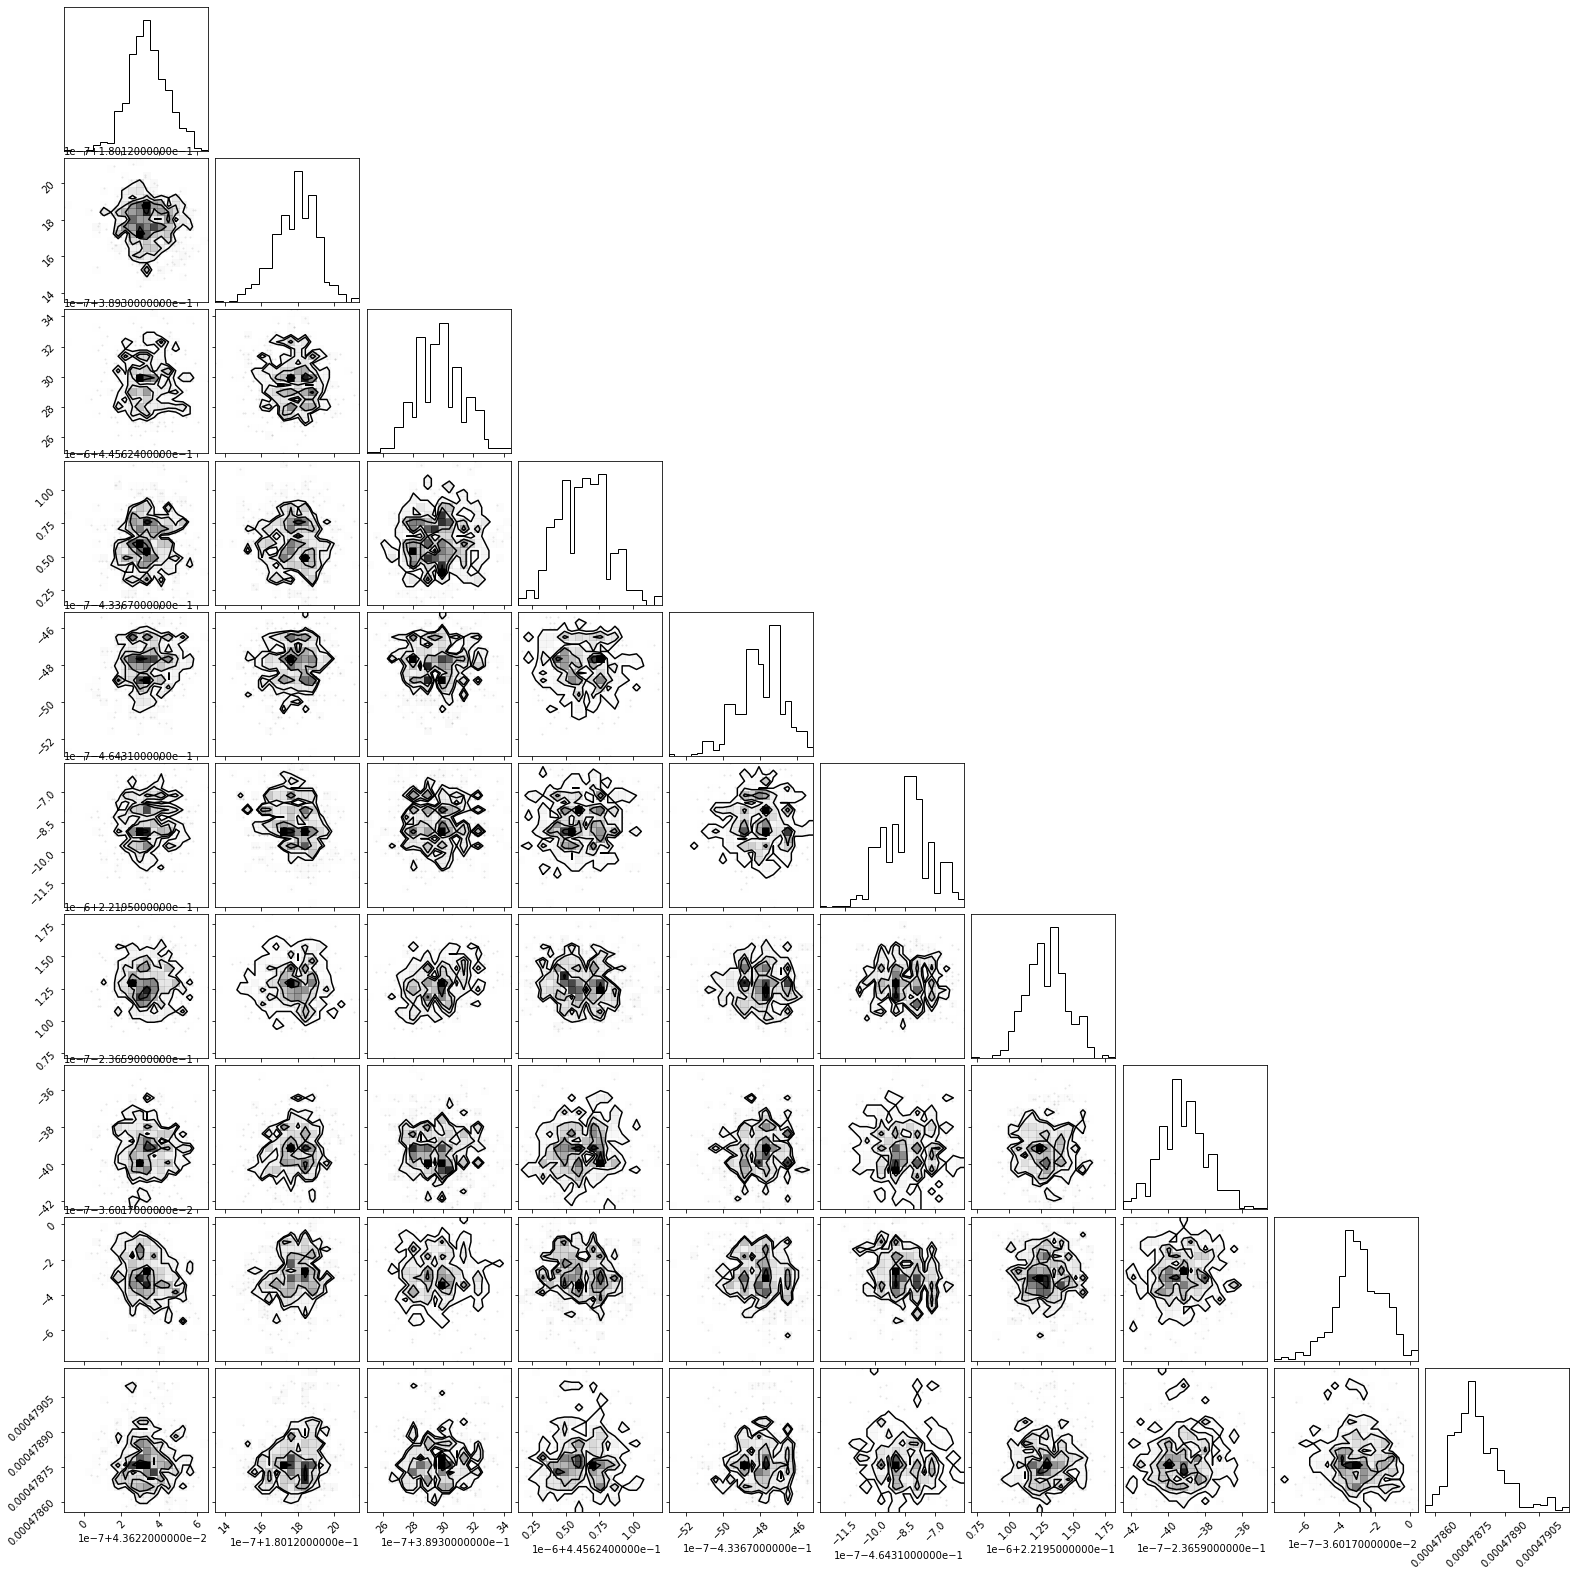

In [21]:
fig = corner.corner(z.detach().numpy()[:, :10])

#### Demo: Samples

In [22]:
%%time
print('Sampling...')
samples = model.sample(32).detach()

Sampling...
CPU times: user 2min 49s, sys: 8.14 s, total: 2min 57s
Wall time: 16.2 s


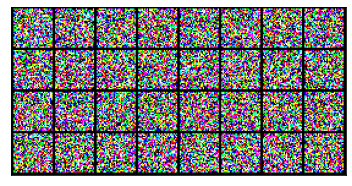

In [23]:
show(make_grid(samples[:32]/255))

In [20]:
# model = Flow(base_dist=StandardNormal((24,8,8)),
#              transforms=[
#                UniformDequantization(num_bits=8),
#                Augment(StandardUniform((3,32,32)), x_size=3),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                Squeeze2d(), Slice(StandardNormal((12,16,16)), num_keep=12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                Squeeze2d(), Slice(StandardNormal((24,8,8)), num_keep=24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#              ]).to(device)

## Trainer

In [24]:
import pytorch_lightning as pl
import math

class LearnerImage(pl.LightningModule):
    def __init__(self, model:nn.Module, hparams):
        super().__init__()
        self.model = model
        self.hparams = hparams

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        x, _ = batch
        
        # loss function
        loss = -self.model.log_prob(x).sum() / (math.log(2) * x.numel())
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)

    def train_dataloader(self):
        return train_loader

In [25]:
# initialize trainer
learn = LearnerImage(model)

In [26]:
n_epochs = 50

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus="0", logger=wandb_logger)

# train model
trainer.fit(learn)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/device_parser.py:135: LightningDeprecationWarning: Parsing of the Trainer argument gpus='0' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 0, but from v1.5 it will select gpus [] (same as gpus=0 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


AttributeError: 'str' object has no attribute 'config'

## Latent Space

In [42]:
%time

z_latent, ldj = model.forward_transform(test_x)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


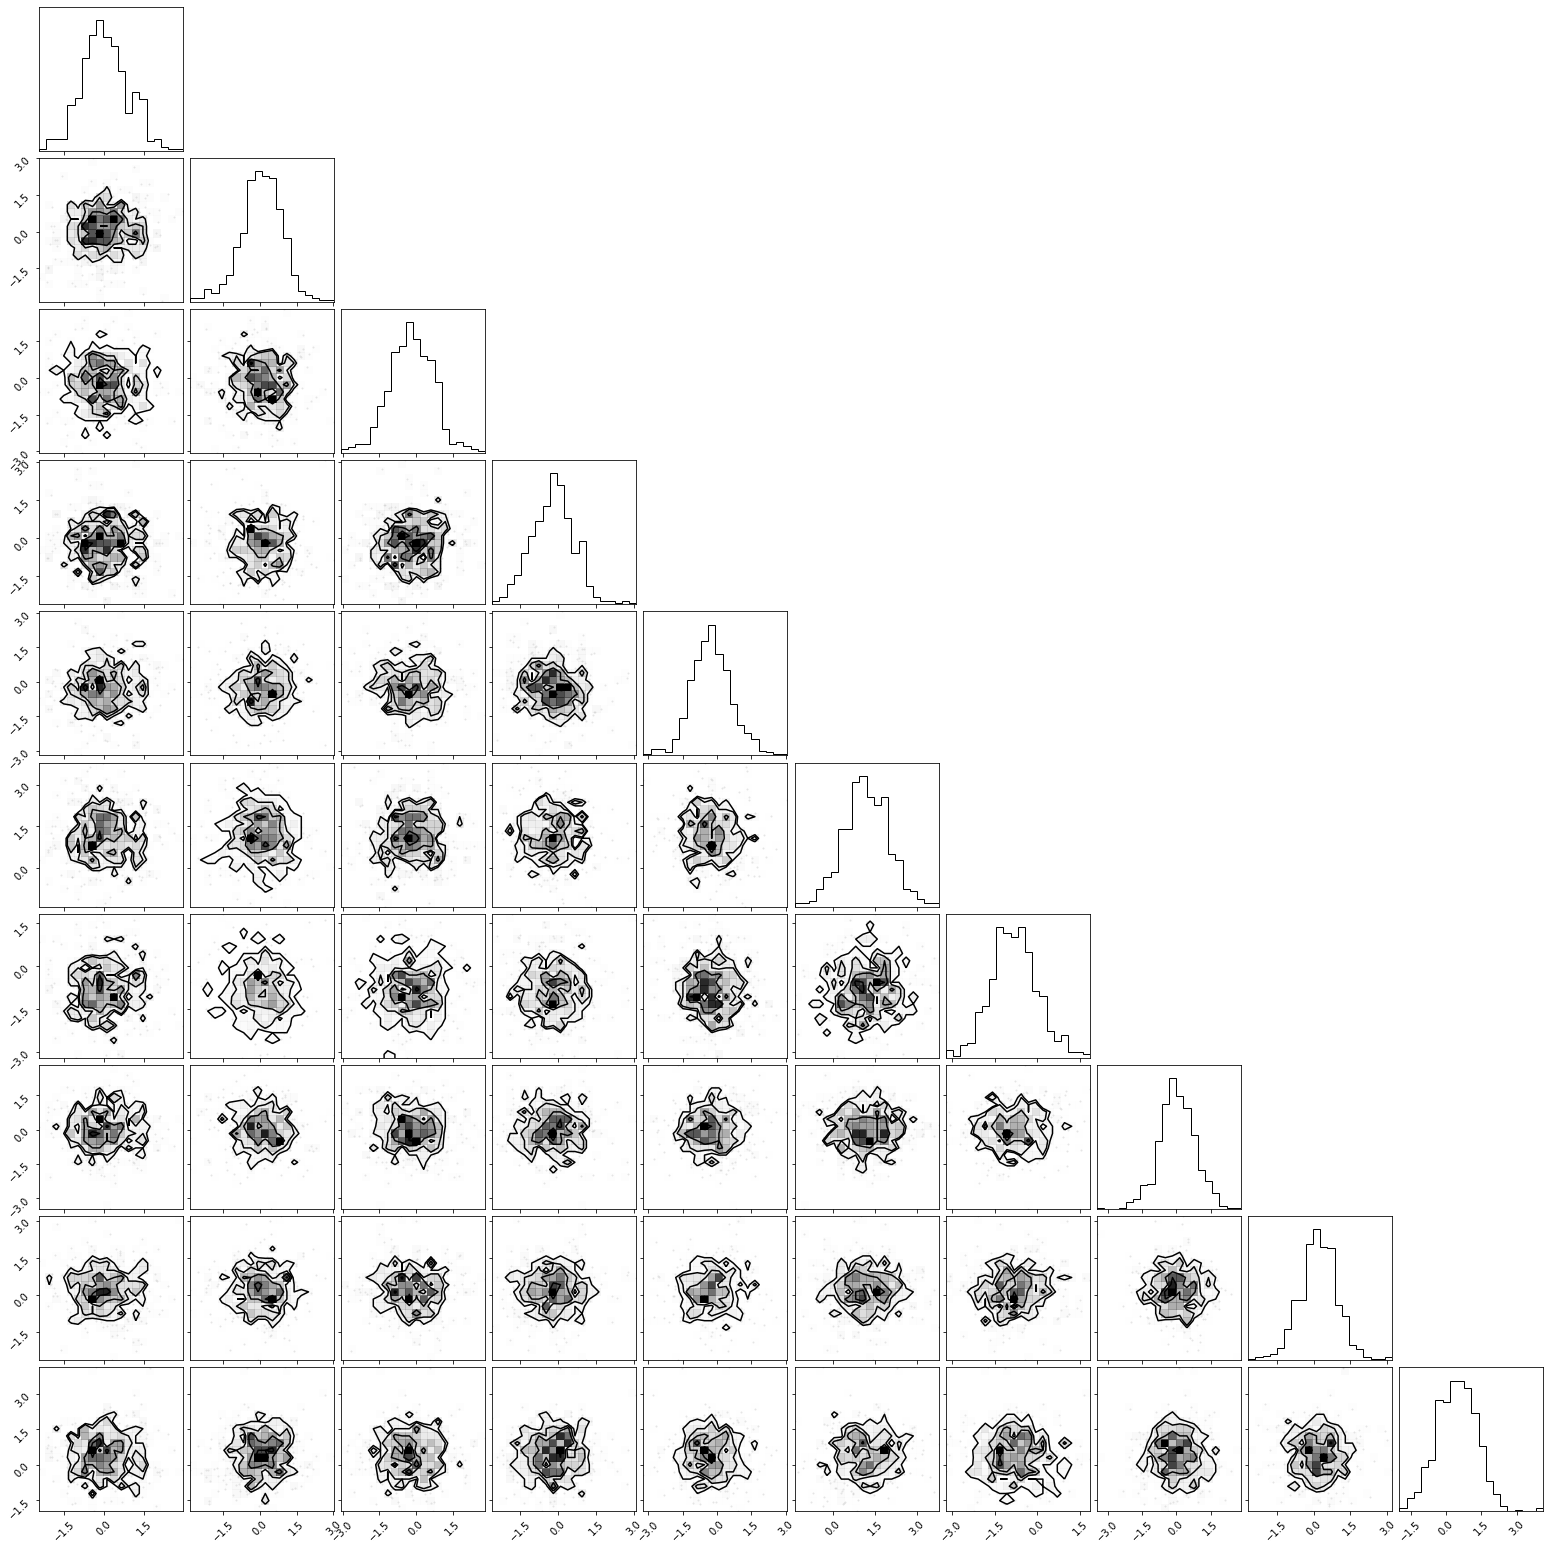

In [43]:
fig = corner.corner(z_latent.detach().numpy()[:, :10])

## Sampling

In [44]:
%%time
print('Sampling...')
samples = model.sample(64).detach()

Sampling...
CPU times: user 2min 11s, sys: 1min 16s, total: 3min 27s
Wall time: 19.1 s


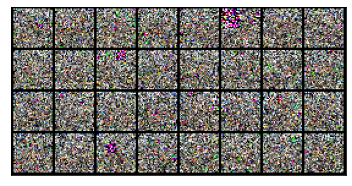

In [45]:
show(make_grid(samples[:32]/255))